# Analyzer configuration for running Table Transformer


In this notebook, we demonstrate how the [Table Transformer](https://github.com/microsoft/table-transformer) models can be utilized for table detection and table segmentation by adjusting the analyzer's default configuration. 

Additionally, we illustrate that modifying downstream parameters might be beneficial as well. We start from the default configuration and improve the quality of page parsing only by changing some processing parameters. The chosen configurations in this notebook may not be optimal, and we recommend continuing experimentation with the parameters, especially if fine-tuning models is not an option.

## General configuration

In [1]:
import os

os.environ["USE_DD_PILLOW"]="True"
os.environ["USE_DD_OPENCV"]="False"

import deepdoctection as dd
from matplotlib import pyplot as plt
from IPython.core.display import HTML

In [ ]:

path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",   # TATR table detection model
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",  # TATR table segmentation model
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",  # we disable Tesseract and use DocTr as OCR engine
    "OCR.USE_TESSERACT=False",
                        ])

The first configuration replaces the default layout and segmentation models with the registered table transformer models. The values need to be the equal to the model names in the `ModelCatalog`. You can find all registered model with `ModelCatalog.get_profile_list()`.

The table recognition model identifies tables again from cropped table regions. This is irrelevant for processing and actually leads to errors. For this reason, category `table` must be filtered out.

```yaml
PT:
   LAYOUT:
      WEIGHTS: microsoft/table-transformer-detection/pytorch_model.bin
   ITEM:
      WEIGHTS: microsoft/table-transformer-structure-recognition/pytorch_model.bin
      FILTER:
         - table
```

[1229 17:17.27 @doctectionpipe.py:84]  INF  Processing 2312.13560_0.pdf
[1229 17:17.28 @context.py:126]  INF  ImageLayoutService total: 0.3408 sec.
[1229 17:17.28 @context.py:126]  INF  SubImageLayoutService total: 0.0634 sec.
[1229 17:17.28 @context.py:126]  INF  PubtablesSegmentationService total: 0.0087 sec.
[1229 17:17.29 @context.py:126]  INF  ImageLayoutService total: 0.3084 sec.
[1229 17:17.29 @context.py:126]  INF  TextExtractionService total: 0.6876 sec.
[1229 17:17.29 @context.py:126]  INF  MatchingService total: 0.0045 sec.
[1229 17:17.29 @context.py:126]  INF  TextOrderService total: 0.0086 sec.


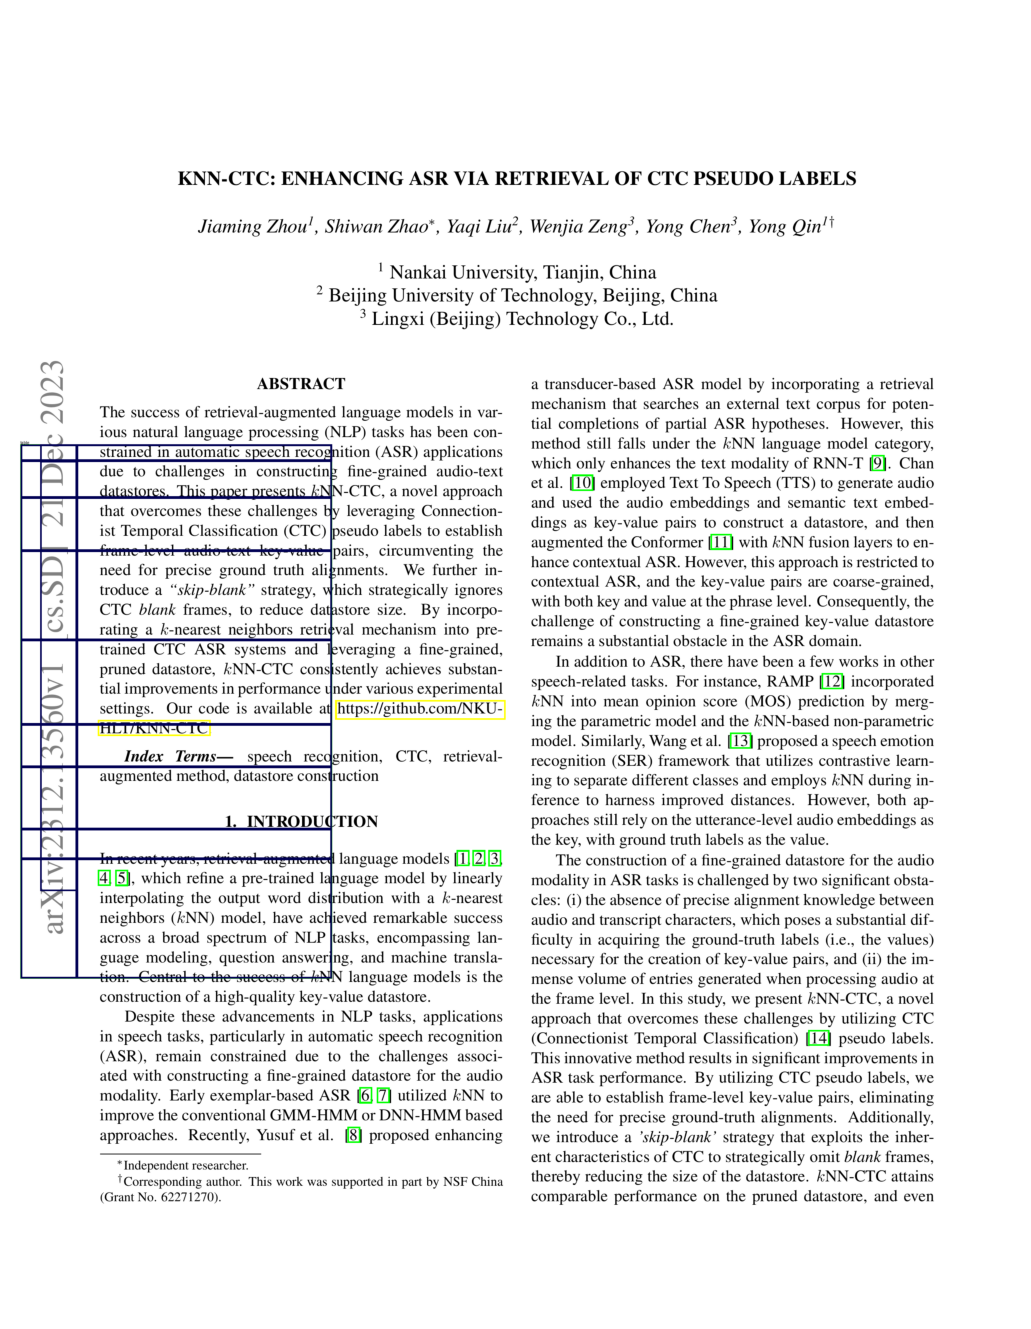

In [3]:
df = analyzer.analyze(path=path)
df.reset_state()
dp = next(iter(df))

np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [4]:
dp.tables[0].csv

[[' ', 'strained in automatic speech '],
 [' ', 'due to challenges in constructing datastores. This paper presents '],
 [' ', 'that overcomes these challenges ist Temporal Classification (CTC) '],
 ['',
  'key-value need for precise ground truth troduce a "skip-blank - strategy, CTC blank frames, to reduce rating a k-nearest neighbors '],
 ['',
  'trained CTC ASR systems and pruned datastore, KNN-CTC tial improvements in performance settings. Our code is available at '],
 ['', 'HLT/KNN-CTC Index Terms- speech '],
 ['', 'augmented method, datastore 1. '],
 [' ', ' '],
 [' ',
  'years, 45), which refine a pre-trained interpolating the output word neighbors (KNN) model, have across a broad spectrum of NLP guage modeling, question answering, ']]

In [5]:
dp.tables[0].score

0.3333275020122528

In [6]:
dp.text

''

Okay, table detection doesn't work at all. Besides that, we see that no text is recognized outside of the table. To suppress this poor table region prediction, we are increasing the filter confidence score to 0.4. We cannot change this directly in the `analyzer` configuration. 

The surrounding text is not displayed because the configuration only outputs the text within a layout segment. In this case, these are only tables. If we set `TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True`, line layout segments will be generated for all words, and all all line segments will be taken into account when generating narrative text.

In [ ]:
path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4  # default threshold is at 0.1

df = analyzer.analyze(path=path)
df.reset_state()
dp = next(iter(df))

np_image = dp.viz()

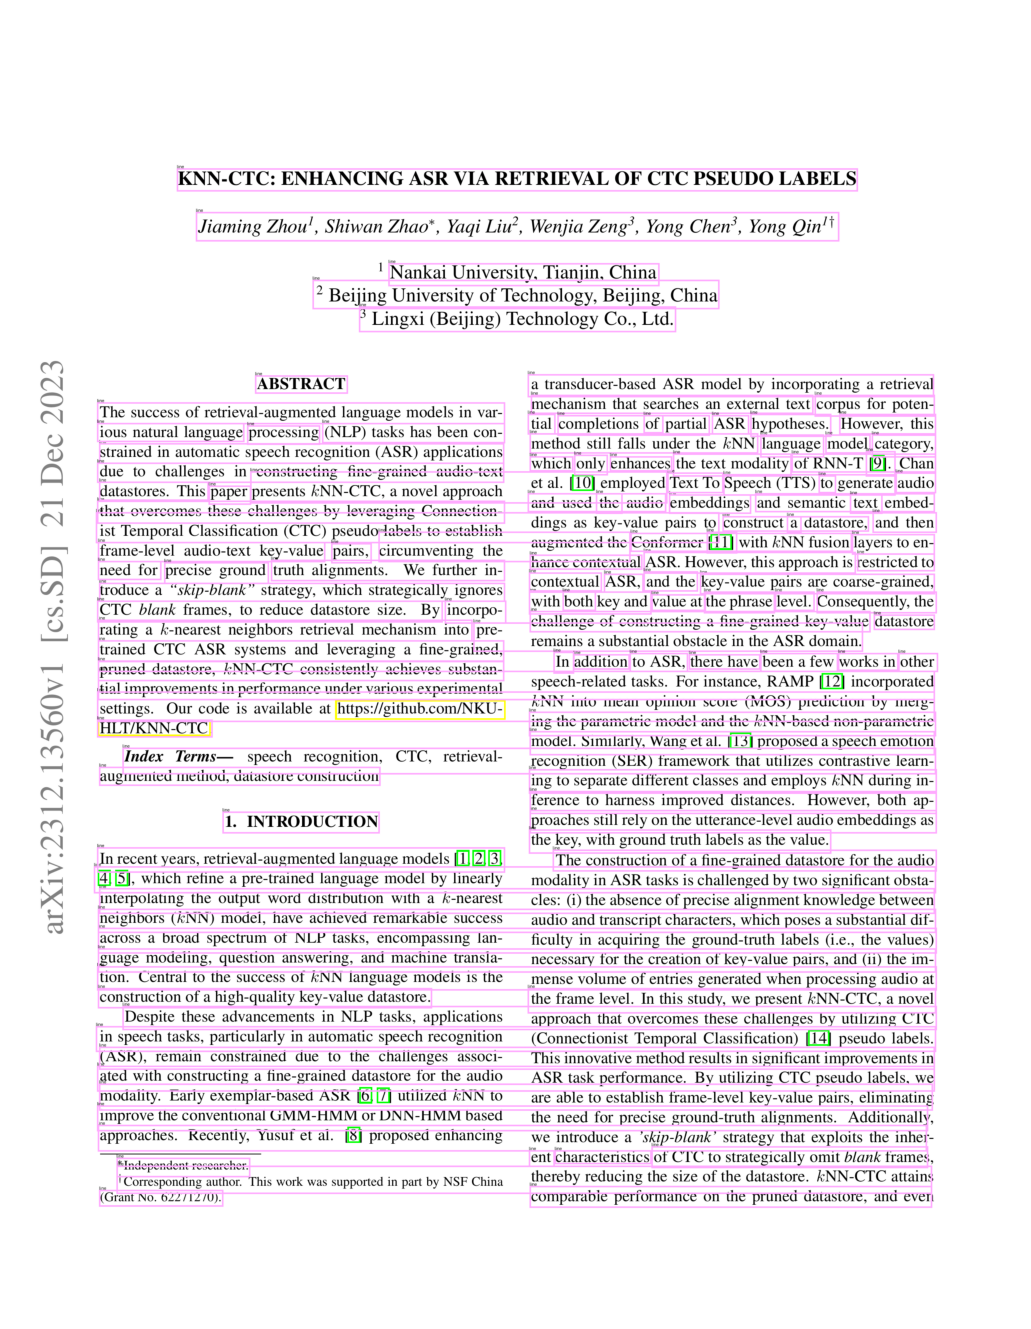

In [8]:
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [9]:
print(dp.text)

KNN-CTC: ENHANCING ASR VIA RETRIEVAL OF CTC PSEUDO LABELS
Jiaming Zhou', Shiwan Zhao*, Yaqi Liu, Wenjia Zeng, Yong Chen, Yong Qin't
Nankai University, Tianjin, China
2 Beijing University of Technology, Beijing, China
3 Lingxi (Beijing) Technology Co., Ltd.
ABSTRACT
a transducer-based ASR model by incorporating a retrieval
mechanism that searches an external text
corpus for poten-
The success of retrieval-augmented language models in var-
tial
completions partial
of
ASR
hypotheses.
However, this
ious natural language
processing
(NLP) tasks has been con-
method still falls under the KNN
language
model
category,
strained in automatic speech recognition (ASR) applications
which
only
enhances
the text modality
of RNN-T Chan
9.
due to challenges in constructing fine-grained audio-text
presents KNN-CTC, a novel approach etal. IOJ employed
Text To
Speech (TTS) generate
audio
datastores. This
paper
to
and used audio
the
embeddings
and semantic embed-
text
ist Temporal Classification (CTC) pseud

The result is not much better. Although we are able to retrieve text outside tables, we observe that the text lines span across multiple columns. This leads to a disastrous outcome in terms of reading order. 

The construction of text lines is done heuristically. In particular, it is determined when adjacent words belong to the same text line and when text lines need to be separated, even if they are at the same horizontal level. 

By reducing the value of `TEXT_ORDERING.PARAGRAPH_BREAK`, we can achieve the splitting of text lines as soon as the word boxes exceed a minimum distance.

In [ ]:
path="/path/to/dir/sample/2312.13560.pdf" # Use the PDF in the sample folder
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",  # default value is at 0.035 which might be too large
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[1229 17:17.51 @doctectionpipe.py:84]  INF  Processing 2312.13560_0.pdf
[1229 17:17.52 @context.py:126]  INF  ImageLayoutService total: 0.0914 sec.
[1229 17:17.52 @context.py:126]  INF  SubImageLayoutService total: 0.0 sec.
[1229 17:17.52 @context.py:126]  INF  PubtablesSegmentationService total: 0.0 sec.
[1229 17:17.52 @context.py:126]  INF  ImageLayoutService total: 0.3113 sec.
[1229 17:17.53 @context.py:126]  INF  TextExtractionService total: 0.5867 sec.
[1229 17:17.53 @context.py:126]  INF  MatchingService total: 0.0027 sec.
[1229 17:17.53 @context.py:126]  INF  TextOrderService total: 0.143 sec.


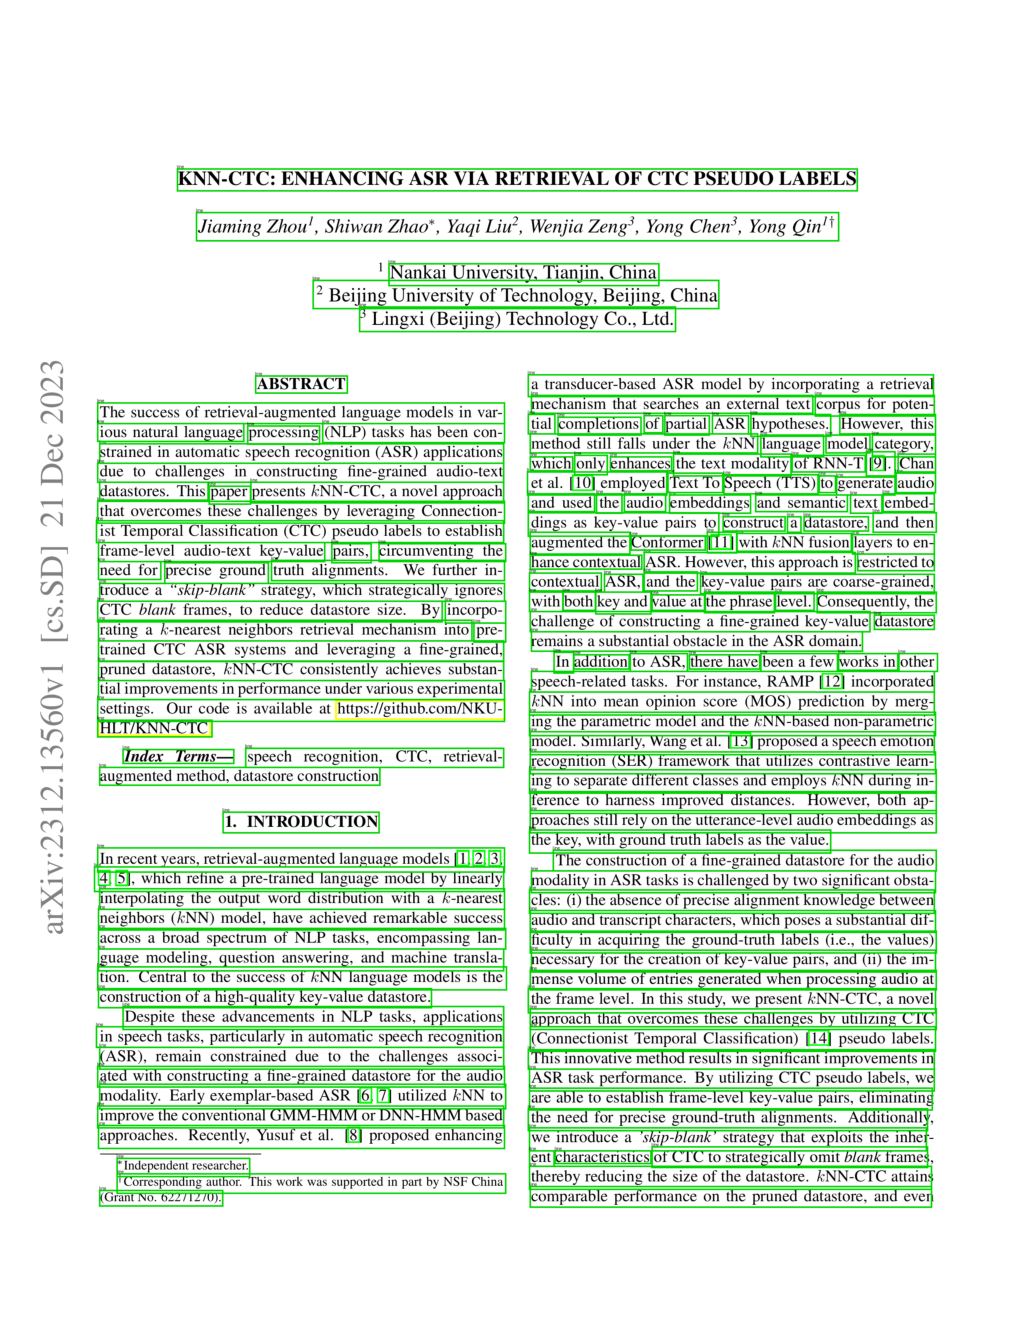

In [11]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [12]:
print(dp.text)

KNN-CTC: ENHANCING ASR VIA RETRIEVAL OF CTC PSEUDO LABELS
Jiaming Zhou', Shiwan Zhao*, Yaqi Liu, Wenjia Zeng, Yong Chen, Yong Qin't
Nankai University, Tianjin, China
2 Beijing University of Technology, Beijing, China
3 Lingxi (Beijing) Technology Co., Ltd.
ABSTRACT
The success of retrieval-augmented language models in var-
ious natural language
processing
(NLP) tasks has been con-
strained in automatic speech recognition (ASR) applications
due to challenges in constructing fine-grained audio-text
datastores. This
paper
presents KNN-CTC, a novel approach
that overcomes these challenges by leveraging Connection-
ist Temporal Classification (CTC) pseudo labels to establish
frame-level audio-text key-value
pairs,
circumventing the
need for
precise ground
truth alignments. We further in-
troduce a "skip-blank - strategy, which strategically ignores
CTC blank frames, to reduce datastore size. By
incorpo-
rating a k-nearest neighbors retrieval mechanism into
pre-
trained CTC ASR systems and l

Okay, this page looks good now. Let's continue scrolling through the document.

[1229 17:18.39 @doctectionpipe.py:84]  INF  Processing 2312.13560_1.pdf
[1229 17:18.40 @context.py:126]  INF  ImageLayoutService total: 0.1056 sec.
[1229 17:18.40 @context.py:126]  INF  SubImageLayoutService total: 0.0572 sec.
[1229 17:18.40 @context.py:126]  INF  PubtablesSegmentationService total: 0.0035 sec.
[1229 17:18.40 @context.py:126]  INF  ImageLayoutService total: 0.2711 sec.
[1229 17:18.41 @context.py:126]  INF  TextExtractionService total: 0.5125 sec.
[1229 17:18.41 @context.py:126]  INF  MatchingService total: 0.0036 sec.
[1229 17:18.41 @context.py:126]  INF  TextOrderService total: 0.0955 sec.


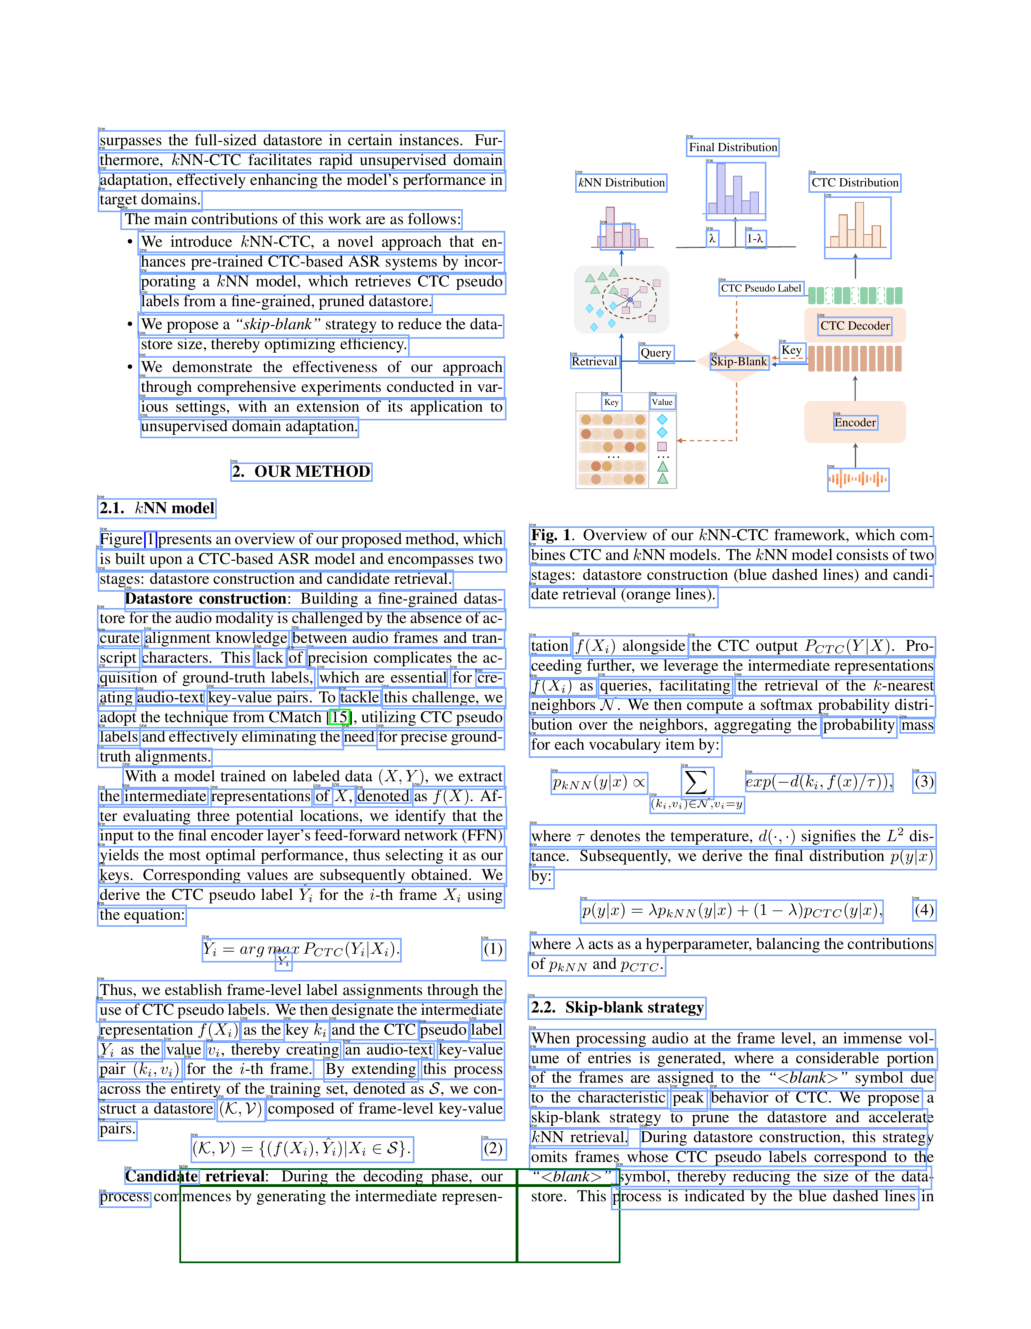

In [13]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

Once again, we observe a false positive, this time with an even higher confidence threshold. We are not going to increase the threshold, though.

In [14]:
dp.tables[0].score

0.6379920840263367

In [14]:
print(dp.text)

surpasses the full-sized datastore in certain instances. Fur-
thermore, KNN-CTC facilitates rapid unsupervised domain
adaptation, effectively enhancing the model's performance in
target domains.
The main contributions of this work are as follows:
We introduce KNN-CTC, a novel approach that en-
hances pre-trained CTC-based ASR systems by incor-
porating a KNN model, which retrieves CTC pseudo
labels from a fine-grained, pruned datastore.
We propose a "skip-blank" strategy to reduce the data-
store size, thereby optimizing efficiency.
We demonstrate the effectiveness of our approach
through comprehensive experiments conducted in var-
ious settings, with an extension of its application to
unsupervised domain adaptation.
2. OUR METHOD
2.1. KNN model
Figurepresents an overview of our proposed method, which
is built upon a CTC-based ASR model and encompasses two
stages: datastore construction and candidate retrieval.
Datastore construction: Building a fine-grained datas-
tore for the audio m

[1229 17:21.53 @doctectionpipe.py:84]  INF  Processing 2312.13560_2.pdf
[1229 17:21.54 @context.py:126]  INF  ImageLayoutService total: 0.1063 sec.
[1229 17:21.54 @context.py:126]  INF  SubImageLayoutService total: 0.0613 sec.
[1229 17:21.54 @context.py:126]  INF  PubtablesSegmentationService total: 0.0188 sec.
[1229 17:21.55 @context.py:126]  INF  ImageLayoutService total: 0.5569 sec.
[1229 17:21.56 @context.py:126]  INF  TextExtractionService total: 0.6682 sec.
[1229 17:21.56 @context.py:126]  INF  MatchingService total: 0.0051 sec.
[1229 17:21.56 @context.py:126]  INF  TextOrderService total: 0.1339 sec.


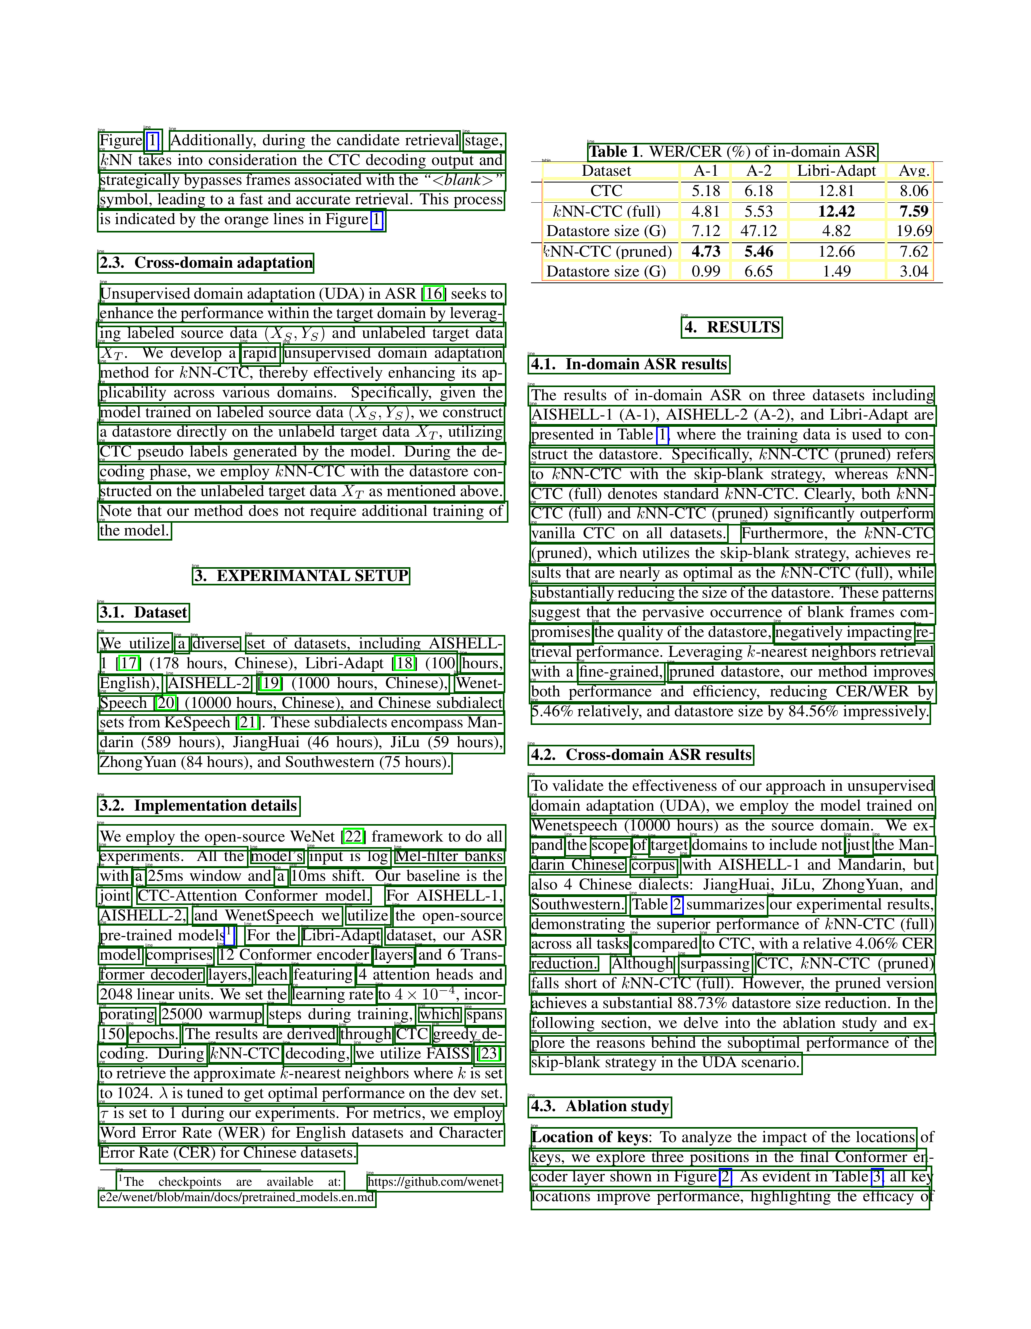

In [15]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

[1229 17:22.29 @doctectionpipe.py:84]  INF  Processing 2312.13560_3.pdf
[1229 17:22.30 @context.py:126]  INF  ImageLayoutService total: 0.1042 sec.
[1229 17:22.30 @context.py:126]  INF  SubImageLayoutService total: 0.1583 sec.
[1229 17:22.30 @context.py:126]  INF  PubtablesSegmentationService total: 0.0433 sec.
[1229 17:22.31 @context.py:126]  INF  ImageLayoutService total: 0.2736 sec.
[1229 17:22.31 @context.py:126]  INF  TextExtractionService total: 0.4839 sec.
[1229 17:22.31 @context.py:126]  INF  MatchingService total: 0.0052 sec.
[1229 17:22.31 @context.py:126]  INF  TextOrderService total: 0.1558 sec.


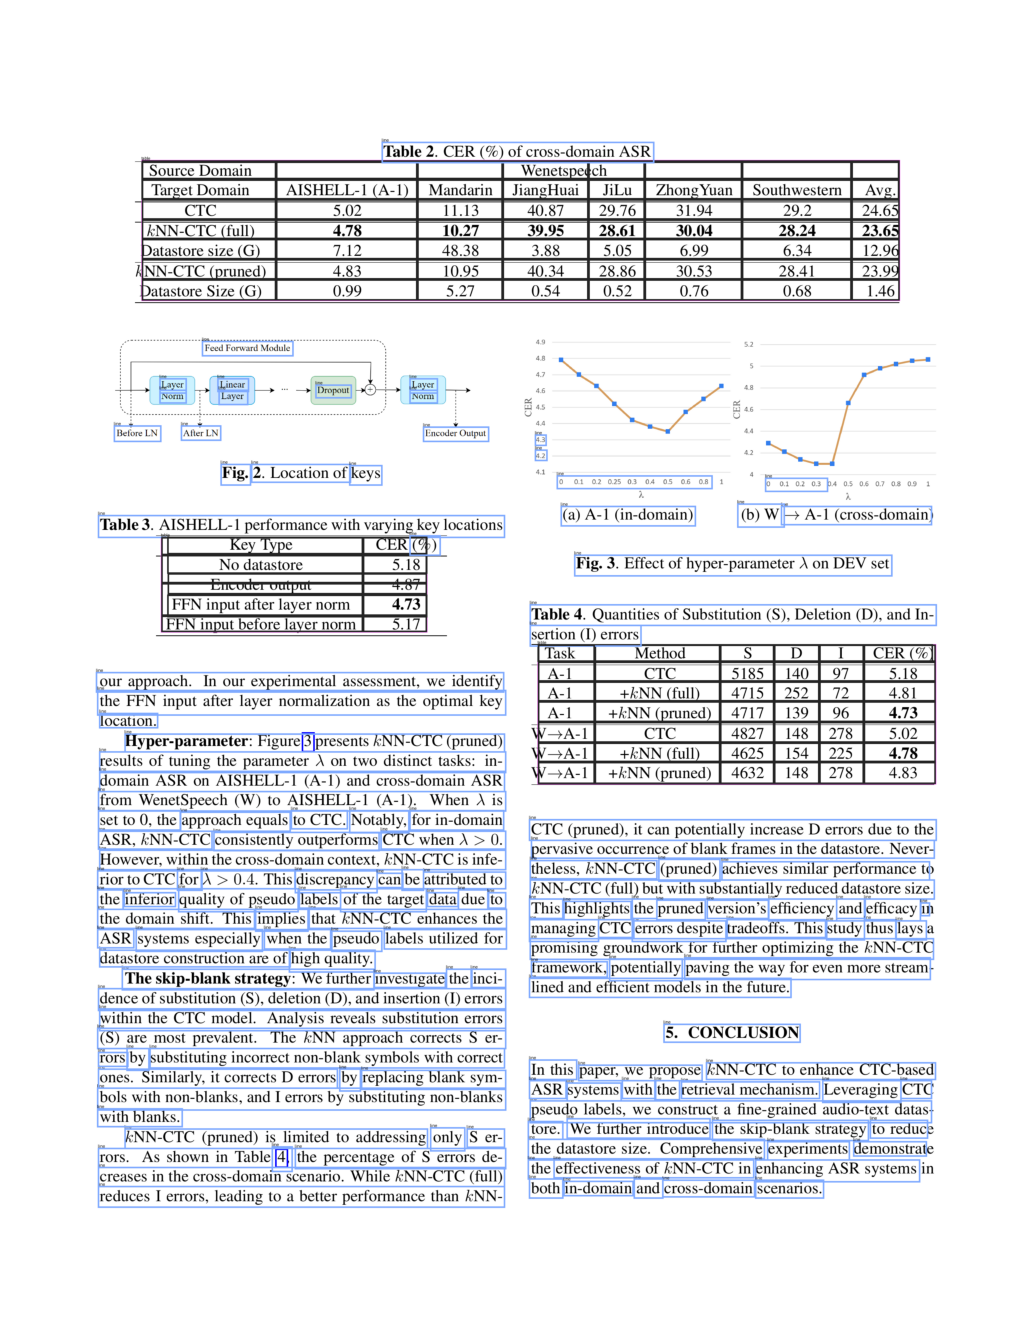

In [16]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

The results now look quite decent, and the segmentation is also yielding usable outcomes. However, as noted in many instances, it should be acknowledged that the models may produce much weaker results on other types of documents.

## Table segmentation

We will now take a look at another example, focusing on optimizations in table segmentation.

In [ ]:
path="/path/to/dir/sample/finance" # Use the PDF in the sample folder
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4  # default threshold is at 0.1

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[1229 17:13.24 @doctectionpipe.py:84]  INF  Processing 1bcac3899c9cb1c0b0f650b1431d3d52_7.png
[1229 17:13.24 @context.py:126]  INF  ImageLayoutService total: 0.0934 sec.
[1229 17:13.25 @context.py:126]  INF  SubImageLayoutService total: 0.1692 sec.
[1229 17:13.25 @context.py:126]  INF  PubtablesSegmentationService total: 0.1383 sec.
[1229 17:13.25 @context.py:126]  INF  ImageLayoutService total: 0.2184 sec.
[1229 17:13.25 @context.py:126]  INF  TextExtractionService total: 0.2555 sec.
[1229 17:13.25 @context.py:126]  INF  MatchingService total: 0.0091 sec.
[1229 17:13.25 @context.py:126]  INF  TextOrderService total: 0.108 sec.


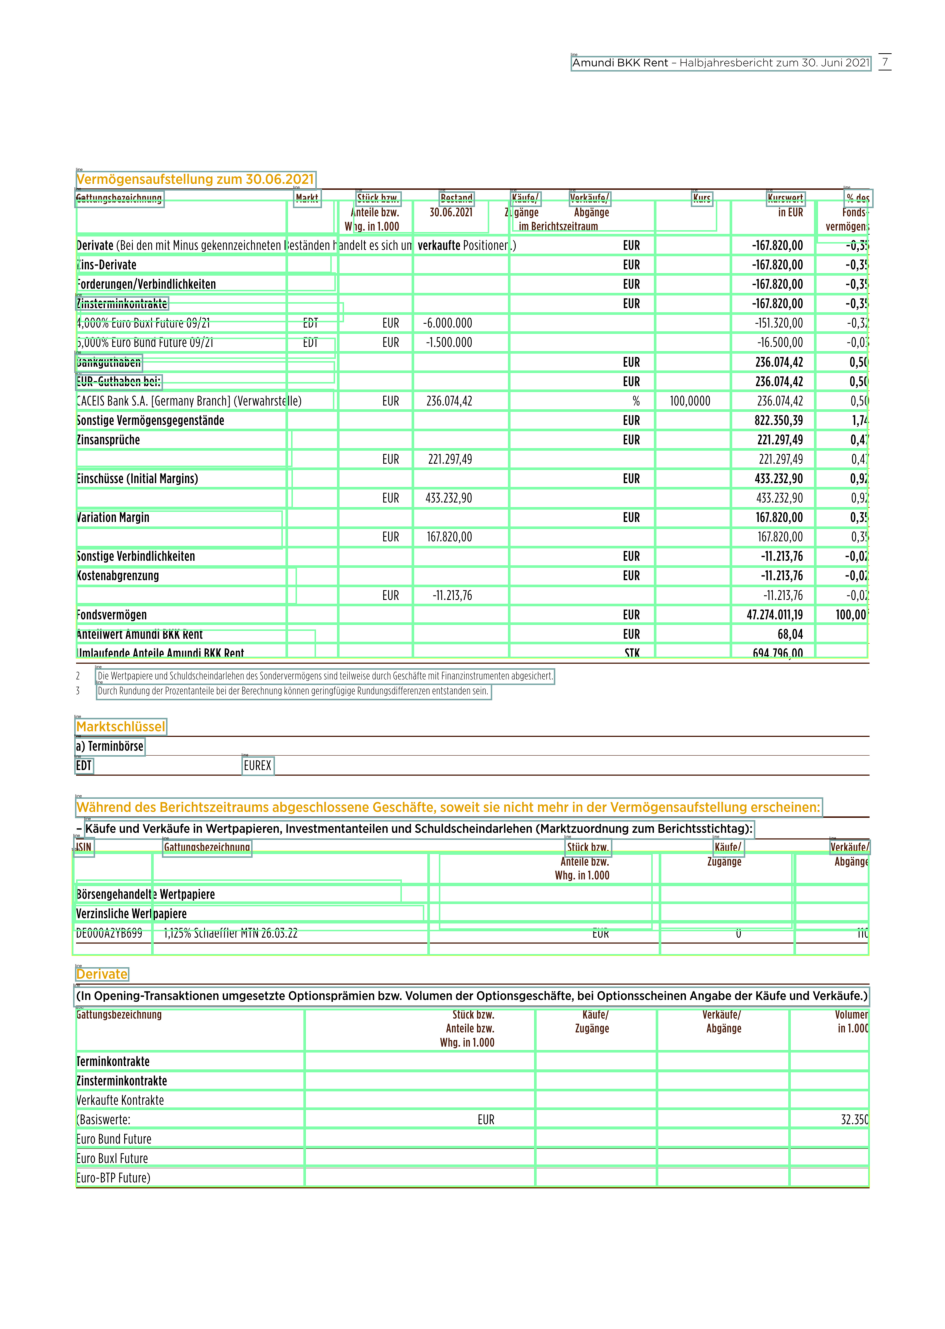

In [22]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [23]:
HTML(dp.tables[0].html)

In [24]:
HTML(dp.tables[1].html)

[1229 17:13.41 @view.py:296]  WRN  html construction not possible
[1229 17:13.41 @view.py:296]  WRN  html construction not possible
[1229 17:13.41 @view.py:296]  WRN  html construction not possible


The table segmentation incorporates various cell types identified by the segmentation model and processes them. Unfortunately, the detection of, for example, spanning cells does not work particularly well. This can be observed from the last sample where the model identifies at first column contains a spanning cell. We want to deactivate this feature. To do this, we need to filter out all cell types.

In [ ]:
path="/path/to/dir/sample/finance" # Use the PDF in the sample folder
    
analyzer =dd.get_dd_analyzer(config_overwrite=
   ["PT.LAYOUT.WEIGHTS=microsoft/table-transformer-detection/pytorch_model.bin",
    "PT.ITEM.WEIGHTS=microsoft/table-transformer-structure-recognition/pytorch_model.bin",
    "PT.ITEM.FILTER=['table','column_header','projected_row_header','spanning']",
    "OCR.USE_DOCTR=True",
    "OCR.USE_TESSERACT=False",
    "TEXT_ORDERING.INCLUDE_RESIDUAL_TEXT_CONTAINER=True",
    "TEXT_ORDERING.PARAGRAPH_BREAK=0.01",
                        ])

analyzer.pipe_component_list[0].predictor.config.threshold = 0.4

df = analyzer.analyze(path=path)
df.reset_state()
df_iter = iter(df)

[1229 17:13.46 @doctectionpipe.py:84]  INF  Processing 1bcac3899c9cb1c0b0f650b1431d3d52_7.png
[1229 17:13.46 @context.py:126]  INF  ImageLayoutService total: 0.1002 sec.
[1229 17:13.46 @context.py:126]  INF  SubImageLayoutService total: 0.1442 sec.
[1229 17:13.46 @context.py:126]  INF  PubtablesSegmentationService total: 0.0911 sec.
[1229 17:13.47 @context.py:126]  INF  ImageLayoutService total: 0.2093 sec.
[1229 17:13.47 @context.py:126]  INF  TextExtractionService total: 0.246 sec.
[1229 17:13.47 @context.py:126]  INF  MatchingService total: 0.0093 sec.
[1229 17:13.47 @context.py:126]  INF  TextOrderService total: 0.0858 sec.


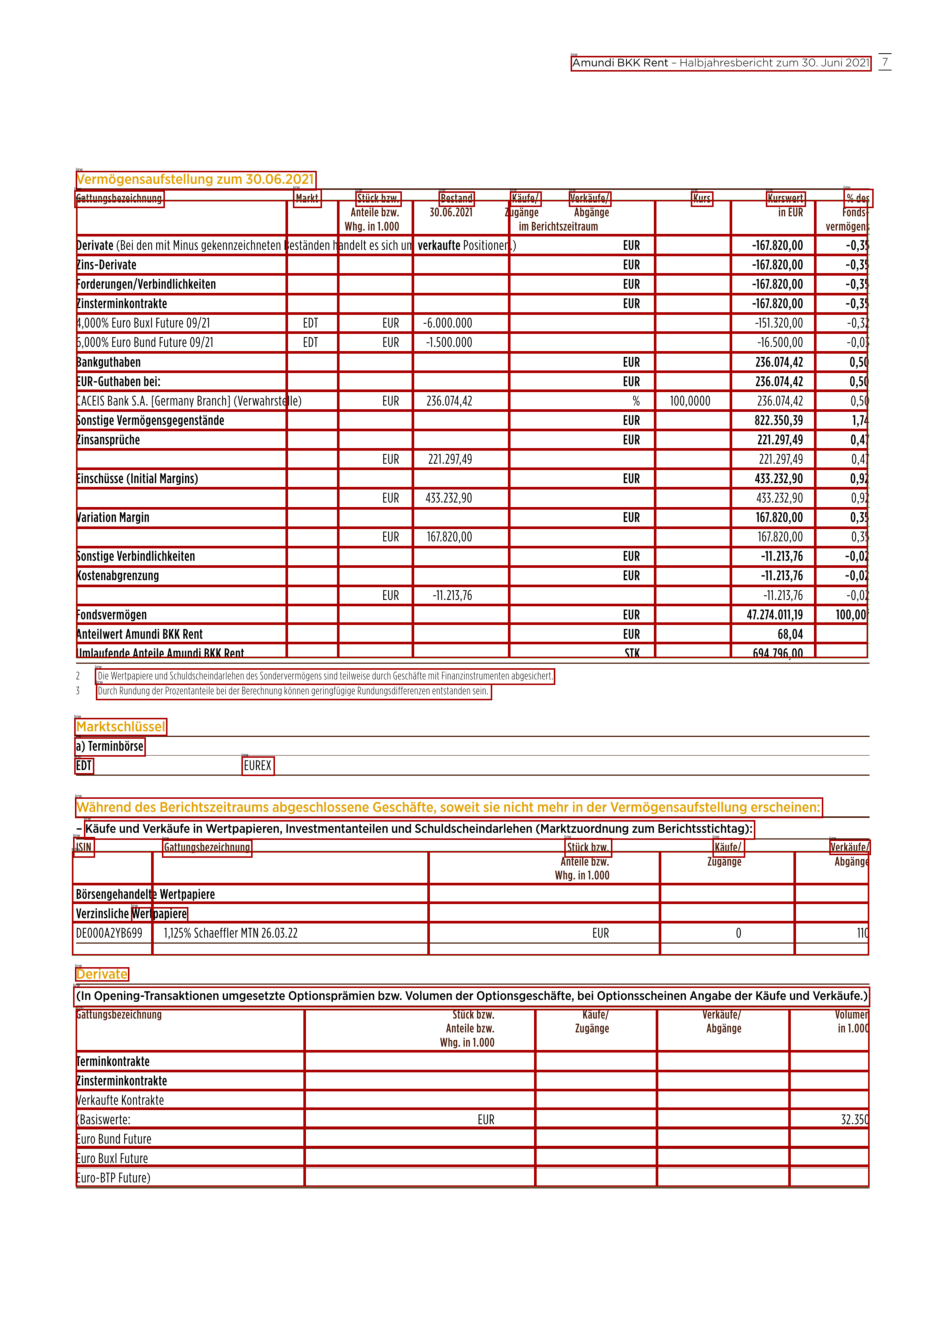

In [26]:
dp = next(df_iter)
np_image = dp.viz()

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(np_image)

In [27]:
HTML(dp.tables[0].html)

In [28]:
HTML(dp.tables[1].html)

In [29]:
HTML(dp.tables[2].html)

As already mentiond, all text that is not part of table cells will be pushed into the narrative text.

In [31]:
print(dp.text)

Amundi BKK Rent - Halbjahresbericht zum 30. Juni 2021
Vermogensaufstelung zum 30.06.2021
Gattungbezeihnung
Markt
Stuck bzw.
Bestand
Kâufe/
Verkâufe/
Kurs
Kurswert
%des
Die Wertpapiere und Schuldscheindarlehen des Sondervermogens sindi teilweise durch Geschâfte mit Finanzinstrumenten abgesichert.
Durch Rundung der Prozentanteile bei der Berechnung kônnen geringfugige Rundungsdifferenzen entstanden sein.
Marktschlussel
a) Terminborse
EDT
EUREX
Wâhrend des Berichtszeitraums abgeschlossene Geschâfte, soweit sie nicht mehr in der Vermogensaufsteluing erscheinen:
Kâufe und Verkâufe in Wertpapieren, Investmentanteilen und Schuldscheindarlehen (Marktzuordnung zum Berichtsstichtag):
ISIN
Gattungsbezeichnung
Stickl bzw.
Kâufe/
Verkâufe/
Wertpapiere
Derivate
(In Opening-Transaktionen umgesetzte Optionspràmien bzw. Volumen der Optionsgeschâfte, bei Optionsscheinen Angabe der Kâufe und Verkâufe.)



There are additional configuration parameters that can improve segmentation. These include, for example, `SEGMENTATION.THRESHOLD_ROWS`, `SEGMENTATION.THRESHOLD_COLS`, `SEGMENTATION.REMOVE_IOU_THRESHOLD_ROWS`, and `SEGMENTATION.REMOVE_IOU_THRESHOLD_COLS`. To observe the effects, we recommend experimenting with these parameters.